In [1]:
from torch import nn

class ConvRelu(nn.Module):
    def __init__(self, *args, **kwargs):
        super(ConvRelu, self).__init__()
        self.conv = nn.Conv2d(*args, **kwargs)
        self.relu = nn.ReLU()
        nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        nn.init.zeros_(self.conv.bias)

    def forward(self, x):
        return self.relu(self.conv(x))


class LinerRelu(nn.Module):
    def __init__(self, *args, dropout=0.5, **kwargs):
        super(LinerRelu, self).__init__()
        self.lin = nn.Linear(*args, **kwargs)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        nn.init.xavier_normal_(self.lin.weight)
        nn.init.zeros_(self.lin.bias)

    def forward(self, x):
        return self.dropout(self.relu(self.lin(x)))

In [2]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.c1 = ConvRelu(1, 96, kernel_size=11, stride=4)
        self.p1 = nn.MaxPool2d(3, 2)
        self.c2 = ConvRelu(96, 256, kernel_size=5, padding=2)
        self.p2 = nn.MaxPool2d(3, 2)
        self.c3 = ConvRelu(256, 384, kernel_size=3, padding=1)
        self.c4 = ConvRelu(384, 384, kernel_size=3, padding=1)
        self.c5 = ConvRelu(384, 256, kernel_size=3, padding=1)
        self.p3 = nn.MaxPool2d(3, 2)
        self.flatten = nn.Flatten()
        self.l1 = LinerRelu(6 * 6 * 256, 4096)
        self.l2 = LinerRelu(4096, 4096)
        self.l3 = LinerRelu(4096, 10)

    def forward(self, x):
        x = self.p1(self.c1(x))
        x = self.p2(self.c2(x))
        x = self.p3(self.c5(self.c4(self.c3(x))))
        x = self.flatten(x)
        x = self.l3(self.l2(self.l1(x)))
        return x

In [3]:
from torchinfo import summary
model = AlexNet()
summary(model, (1, 1, 227, 227))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 10]                   --
├─ConvRelu: 1-1                          [1, 96, 55, 55]           --
│    └─Conv2d: 2-1                       [1, 96, 55, 55]           11,712
│    └─ReLU: 2-2                         [1, 96, 55, 55]           --
├─MaxPool2d: 1-2                         [1, 96, 27, 27]           --
├─ConvRelu: 1-3                          [1, 256, 27, 27]          --
│    └─Conv2d: 2-3                       [1, 256, 27, 27]          614,656
│    └─ReLU: 2-4                         [1, 256, 27, 27]          --
├─MaxPool2d: 1-4                         [1, 256, 13, 13]          --
├─ConvRelu: 1-5                          [1, 384, 13, 13]          --
│    └─Conv2d: 2-5                       [1, 384, 13, 13]          885,120
│    └─ReLU: 2-6                         [1, 384, 13, 13]          --
├─ConvRelu: 1-6                          [1, 384, 13, 13]          --
│

In [4]:
class AlexNetSmall(nn.Module):
    def __init__(self, dropout=0.5):
        super(AlexNetSmall, self).__init__()
        self.c1 = ConvRelu(1, 96, kernel_size=11, stride=4)
        self.p1 = nn.MaxPool2d(3, 2)
        self.c2 = ConvRelu(96, 256, kernel_size=5, padding=2)
        self.p2 = nn.MaxPool2d(3, 2)
        self.c3 = ConvRelu(256, 384, kernel_size=3, padding=1)
        self.c4 = ConvRelu(384, 384, kernel_size=3, padding=1)
        self.c5 = ConvRelu(384, 256, kernel_size=3, padding=1)
        self.p3 = nn.MaxPool2d(3, 2)
        self.flatten = nn.Flatten()
        self.l1 = LinerRelu(256, 128, dropout=dropout)
        self.l2 = LinerRelu(128, 128, dropout=dropout)
        self.l3 = LinerRelu(128, 10)

    def forward(self, x):
        x = self.p1(self.c1(x))
        x = self.p2(self.c2(x))
        x = self.p3(self.c5(self.c4(self.c3(x))))
        x = self.flatten(x)
        x = self.l3(self.l2(self.l1(x)))
        return x

In [5]:
model_small= AlexNetSmall()
summary(model_small, (1, 1, 67, 67))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNetSmall                             [1, 10]                   --
├─ConvRelu: 1-1                          [1, 96, 15, 15]           --
│    └─Conv2d: 2-1                       [1, 96, 15, 15]           11,712
│    └─ReLU: 2-2                         [1, 96, 15, 15]           --
├─MaxPool2d: 1-2                         [1, 96, 7, 7]             --
├─ConvRelu: 1-3                          [1, 256, 7, 7]            --
│    └─Conv2d: 2-3                       [1, 256, 7, 7]            614,656
│    └─ReLU: 2-4                         [1, 256, 7, 7]            --
├─MaxPool2d: 1-4                         [1, 256, 3, 3]            --
├─ConvRelu: 1-5                          [1, 384, 3, 3]            --
│    └─Conv2d: 2-5                       [1, 384, 3, 3]            885,120
│    └─ReLU: 2-6                         [1, 384, 3, 3]            --
├─ConvRelu: 1-6                          [1, 384, 3, 3]            --
│

In [6]:
%run utils.py

In [7]:
from torchvision import datasets, transforms
from utils import train_val_split

full = datasets.FashionMNIST(root='./data', train=True, download=True)
test = datasets.FashionMNIST(root='./data', train=False, download=True)
train, valid = train_val_split(full, seed=666)

print(len(train), len(valid), len(test))

50000 10000 10000


In [8]:
from utils import PackDataset

trans = transforms.Compose([transforms.Resize(size=67), transforms.ToTensor()])
train_data = PackDataset(train, transform=trans)
valid_data = PackDataset(valid, transform=trans)
test_data = PackDataset(test, transform=trans)

image, label = train_data[0]
print(image.size())

torch.Size([1, 67, 67])


In [9]:
from skorch.callbacks import EarlyStopping, Checkpoint, EpochScoring, LRScheduler, ProgressBar
from torch.optim.lr_scheduler import CosineAnnealingLR

def control_callbacks(
        epochs, show_bar=True,
        model_name='best_model.pt', check_dir='./data/checkpoints'
    ):
    bar = ProgressBar()
    lr_scheduler = LRScheduler(policy=CosineAnnealingLR, T_max=epochs)
    early_stopping = EarlyStopping(monitor='valid_acc', lower_is_better=False, patience=6)
    train_acc = EpochScoring(name='train_acc', scoring='accuracy', on_train=True)
    check_point = Checkpoint(
        dirname=check_dir, f_params=model_name,
        monitor='valid_acc_best', load_best=True
    )
    calls = []
    if show_bar:
        calls.append(bar)
    calls.extend([lr_scheduler, early_stopping, train_acc, check_point])
    return calls

In [10]:
import numpy as np

def get_train_labels(dataset):
    return np.array([y for x, y in iter(train_data)])

In [12]:
import torch

from skorch import NeuralNetClassifier
from skorch.helper import predefined_split

epochs = 50
calls = control_callbacks(epochs, check_dir='./data/alex-checkpoints')
y_train_data = np.array([y for x, y in iter(train_data)])
net = NeuralNetClassifier(
    AlexNetSmall,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    lr=0.001,
    batch_size=2048,
    max_epochs=epochs,
    train_split=predefined_split(valid_data),
    device='cuda' if torch.cuda.is_available() else 'cpu',
    callbacks=calls
)
net.fit(X=train_data, y=get_train_labels(train_data))

  0%|          | 0/30 [00:00<?, ?it/s]

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      lr      dur
-------  -----------  ------------  -----------  ------------  ----  ------  -------
      1       0.1441        2.3336       0.3858        2.0895     +  0.0010  13.2995


  0%|          | 0/30 [00:00<?, ?it/s]

      2       0.2636        2.0439       0.6520        1.5392     +  0.0010  13.1191


  0%|          | 0/30 [00:00<?, ?it/s]

      3       0.3376        1.8592       0.6877        1.3037     +  0.0010  13.1583


  0%|          | 0/30 [00:00<?, ?it/s]

      4       0.3846        1.7512       0.7932        1.1307     +  0.0010  12.9410


  0%|          | 0/30 [00:00<?, ?it/s]

      5       0.4083        1.6689       0.8074        1.0124     +  0.0010  13.1957


  0%|          | 0/30 [00:00<?, ?it/s]

      6       0.4259        1.6056       0.8176        0.8865     +  0.0010  13.0467


  0%|          | 0/30 [00:00<?, ?it/s]

      7       0.4364        1.5653       0.8286        0.8064     +  0.0010  13.4019


  0%|          | 0/30 [00:00<?, ?it/s]

      8       0.4423        1.5369       0.8255        0.8325        0.0010  13.1706


  0%|          | 0/30 [00:00<?, ?it/s]

      9       0.4471        1.5128       0.8561        0.7965     +  0.0009  13.0148


  0%|          | 0/30 [00:00<?, ?it/s]

     10       0.4494        1.4940       0.8569        0.6998     +  0.0009  13.2124


  0%|          | 0/30 [00:00<?, ?it/s]

     11       0.4552        1.4774       0.8695        0.6933     +  0.0009  13.0669


  0%|          | 0/30 [00:00<?, ?it/s]

     12       0.4642        1.4497       0.8700        0.6876     +  0.0009  13.2877


  0%|          | 0/30 [00:00<?, ?it/s]

     13       0.4689        1.4366       0.8871        0.6331     +  0.0009  13.0815


  0%|          | 0/30 [00:00<?, ?it/s]

     14       0.4786        1.4117       0.8899        0.5812     +  0.0008  13.1109


  0%|          | 0/30 [00:00<?, ?it/s]

     15       0.4745        1.4121       0.8851        0.5909        0.0008  13.2775


  0%|          | 0/30 [00:00<?, ?it/s]

     16       0.4798        1.3969       0.8940        0.5808     +  0.0008  13.0557


  0%|          | 0/30 [00:00<?, ?it/s]

     17       0.4825        1.3869       0.8852        0.5808        0.0008  13.1436


  0%|          | 0/30 [00:00<?, ?it/s]

     18       0.4882        1.3723       0.8905        0.5612        0.0007  13.3458


  0%|          | 0/30 [00:00<?, ?it/s]

     19       0.4906        1.3624       0.8940        0.5237        0.0007  13.2726


  0%|          | 0/30 [00:00<?, ?it/s]

     20       0.4909        1.3577       0.9008        0.5141     +  0.0007  13.3936


  0%|          | 0/30 [00:00<?, ?it/s]

     21       0.4893        1.3549       0.9037        0.4950     +  0.0007  13.1622


  0%|          | 0/30 [00:00<?, ?it/s]

     22       0.4909        1.3483       0.9018        0.5246        0.0006  13.4500


  0%|          | 0/30 [00:00<?, ?it/s]

     23       0.4926        1.3444       0.9058        0.4859     +  0.0006  13.2340


  0%|          | 0/30 [00:00<?, ?it/s]

     24       0.4984        1.3225       0.9079        0.4973     +  0.0006  13.3140


  0%|          | 0/30 [00:00<?, ?it/s]

     25       0.4991        1.3251       0.9109        0.4996     +  0.0005  13.4630


  0%|          | 0/30 [00:00<?, ?it/s]

     26       0.5023        1.3101       0.9128        0.4568     +  0.0005  13.2256


  0%|          | 0/30 [00:00<?, ?it/s]

     27       0.5024        1.3067       0.9106        0.4617        0.0005  13.4605


  0%|          | 0/30 [00:00<?, ?it/s]

     28       0.5027        1.3014       0.9119        0.4416        0.0004  13.2647


  0%|          | 0/30 [00:00<?, ?it/s]

     29       0.5040        1.3016       0.9116        0.4457        0.0004  13.2312


  0%|          | 0/30 [00:00<?, ?it/s]

     30       0.5017        1.3018       0.9103        0.4516        0.0004  13.4780


  0%|          | 0/30 [00:00<?, ?it/s]

     31       0.5052        1.2902       0.9152        0.4299     +  0.0003  13.2100


  0%|          | 0/30 [00:00<?, ?it/s]

     32       0.5044        1.2885       0.9084        0.4518        0.0003  13.3376


  0%|          | 0/30 [00:00<?, ?it/s]

     33       0.5091        1.2786       0.9121        0.4286        0.0003  13.1466


  0%|          | 0/30 [00:00<?, ?it/s]

     34       0.5071        1.2844       0.9074        0.4425        0.0003  13.4366


  0%|          | 0/30 [00:00<?, ?it/s]

     35       0.5108        1.2704       0.9151        0.4312        0.0002  13.2725


  0%|          | 0/30 [00:00<?, ?it/s]

     36       0.5107        1.2674       0.9150        0.4234        0.0002  13.2789


  0%|          | 0/30 [00:00<?, ?it/s]

Stopping since valid_acc has not improved in the last 6 epochs.


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=AlexNetSmall(
    (c1): ConvRelu(
      (conv): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
      (relu): ReLU()
    )
    (p1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (c2): ConvRelu(
      (conv): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (relu): ReLU()
    )
    (p2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (c3): ConvRelu(
      (conv): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (c4): ConvRelu(
      (conv): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (c5): ConvRelu(
      (conv): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (p3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (l1): LinerRelu(
      (lin): Linear(in_features=256, out_features=128, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (l2): LinerRelu(
      (lin): Linear(in_features=128, out_features=128, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (l3): LinerRelu(
      (lin): Linear(in_features=128, out_features=10, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.5, inplace=False)
    )
  ),
)

In [13]:
import matplotlib.pyplot as plt

def plot_history(net):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.plot(net.history[:, 'train_loss'], label='Train Loss', linewidth=3)
    ax1.plot(net.history[:, 'valid_loss'], label='Valid Loss', linewidth=3)
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.set_title('Training & Validation Loss', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax1.legend()

    ax2.plot(net.history[:, 'train_acc'], label='Train Accuracy', linewidth=3)
    ax2.plot(net.history[:, 'valid_acc'], label='Valid Accuracy', linewidth=3)
    ax2.set_xlabel('Epoch', fontsize=14)
    ax2.set_ylabel('Accuracy (%)', fontsize=14)
    ax2.set_title('Validation Accuracy', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax2.legend()

    plt.tight_layout() 
    plt.show()

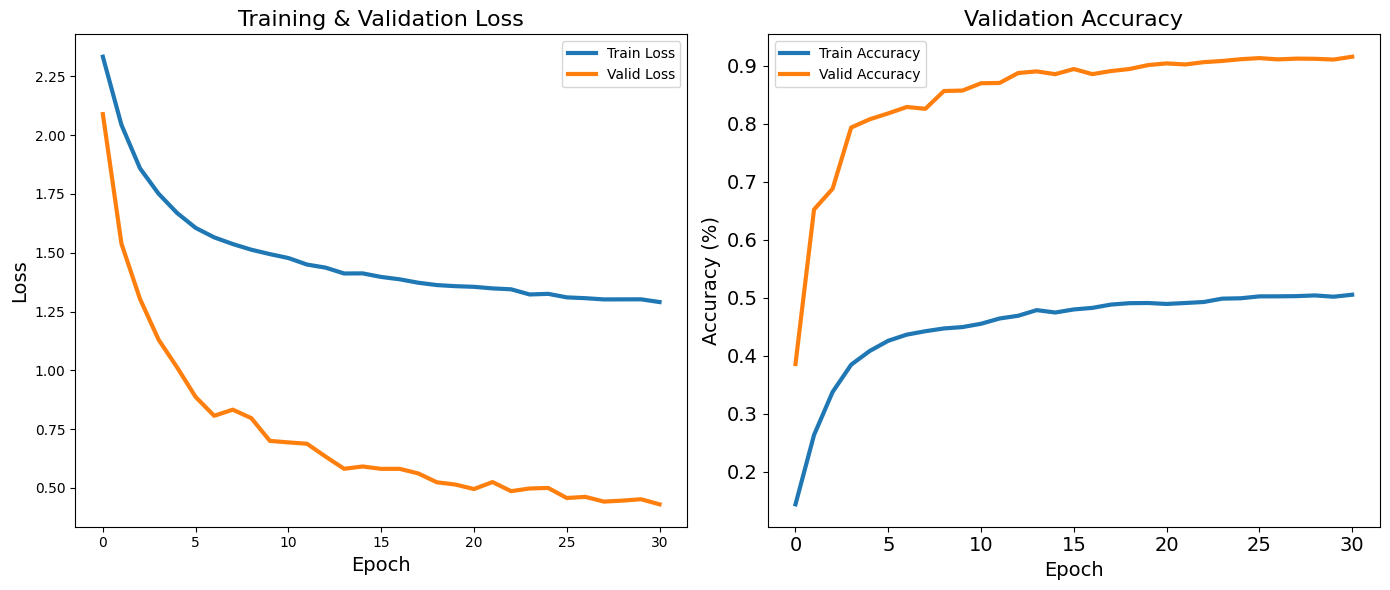

In [14]:
plot_history(net)

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def check_result(net, test_data):
    y_pred = net.predict(test_data) 
    y_prob = net.predict_proba(test_data) 
    y_true = np.array([y for x, y in iter(test_data)])     
    test_accuracy = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print('='*100)

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap="Blues",
        annot_kws={"size": 10},
    )
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.title("Confusion Matrix (Test Set)", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
    print('='*100)
    y_hat = np.asarray(y_true)                 
    wrong_idx = np.where(y_pred != y_hat)[0]
    error_list = []
    for i in wrong_idx:
        features, _ = test_data[i]                  
        error_list.append({
            "features": features,              
            "true_label": int(y_hat[i]),
            "pred_label": int(y_pred[i]),
            "probabilities": y_prob[i]      
        })

    print(f'error number: {len(error_list)}')
    return error_list

Test Accuracy: 0.9111
Confusion Matrix:
 [[876   0   9  16   3   1  87   0   8   0]
 [  3 976   0  11   2   0   6   0   2   0]
 [ 17   0 859  11  47   0  65   0   1   0]
 [  6   1   6 943  17   0  26   0   1   0]
 [  1   1  67  32 815   0  83   0   1   0]
 [  0   0   0   0   0 985   0  11   0   4]
 [110   0  65  35  49   0 733   0   8   0]
 [  0   0   0   0   0  11   0 972   0  17]
 [  1   0   3   4   0   2   3   2 985   0]
 [  0   0   0   0   0   6   1  26   0 967]]


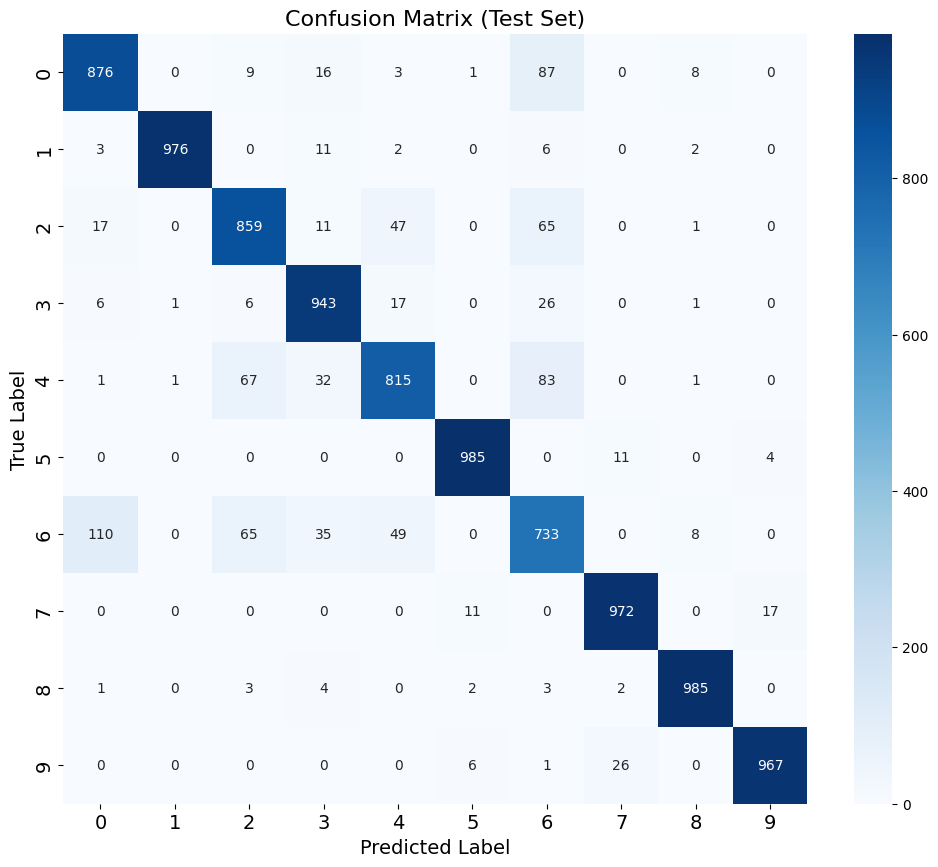

error number: 889


[{'features': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  'true_label': 7,
  'pred_label': 5,
  'probabilities': array([0.02037189, 0.02037189, 0.02037189, 0.02037189, 0.02037189,
         0.8166529 , 0.02037189, 0.02037189, 0.02037189, 0.02037189],
        dtype=float32)},
 {'features': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  'true_label': 4,
  'pred_label': 2,
  'probabilities': array([0.07866815, 0.07866815, 0.19890684, 0.07866815, 0.17174791,
         0.07866815, 0.07866815, 0.07866815, 0.07866815, 0.07866815],
        d

In [16]:
check_result(net, test_data)

In [17]:
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier

def get_train_features(dataset):
    return np.array([x[0].float() for x in dataset])

params = {
    'lr': [0.01, 0.005],
    'batch_size': [2048],
}

epochs = 1
calls = control_callbacks(epochs, check_dir='./data/alex-checkpoints')
search_net = NeuralNetClassifier(
    AlexNetSmall,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    lr=0.01,
    batch_size=2048,
    max_epochs=epochs,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    callbacks=calls
)

gs = GridSearchCV(search_net, param_grid=params, scoring='accuracy', verbose=2)
gs.fit(X=get_train_features(train_data), y=get_train_labels(train_data))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


  0%|          | 0/20 [00:00<?, ?it/s]

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      lr     dur
-------  -----------  ------------  -----------  ------------  ----  ------  ------
      1       0.0999       29.9489       0.1003        2.3026     +  0.0100  3.1608
[CV] END ...........................batch_size=2048, lr=0.01; total time=   4.0s


  0%|          | 0/20 [00:00<?, ?it/s]

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      lr     dur
-------  -----------  ------------  -----------  ------------  ----  ------  ------
      1       0.1003       18.6907       0.1004        2.3026     +  0.0100  3.3074
[CV] END ...........................batch_size=2048, lr=0.01; total time=   4.2s


  0%|          | 0/20 [00:00<?, ?it/s]

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      lr     dur
-------  -----------  ------------  -----------  ------------  ----  ------  ------
      1       0.1005       36.6395       0.1004        2.3026     +  0.0100  3.0328
[CV] END ...........................batch_size=2048, lr=0.01; total time=   3.9s


  0%|          | 0/20 [00:00<?, ?it/s]

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      lr     dur
-------  -----------  ------------  -----------  ------------  ----  ------  ------
      1       0.1000       31.5855       0.1004        2.3026     +  0.0100  3.0579
[CV] END ...........................batch_size=2048, lr=0.01; total time=   3.9s


  0%|          | 0/20 [00:00<?, ?it/s]

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      lr     dur
-------  -----------  ------------  -----------  ------------  ----  ------  ------
      1       0.0998       31.7892       0.1004        2.3026     +  0.0100  3.0546
[CV] END ...........................batch_size=2048, lr=0.01; total time=   3.9s


  0%|          | 0/20 [00:00<?, ?it/s]

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      lr     dur
-------  -----------  ------------  -----------  ------------  ----  ------  ------
      1       0.1009        7.0799       0.1003        2.3026     +  0.0050  3.1061
[CV] END ..........................batch_size=2048, lr=0.005; total time=   4.0s


  0%|          | 0/20 [00:00<?, ?it/s]

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      lr     dur
-------  -----------  ------------  -----------  ------------  ----  ------  ------
      1       0.0997        4.3255       0.1004        2.3026     +  0.0050  3.3182
[CV] END ..........................batch_size=2048, lr=0.005; total time=   4.2s


  0%|          | 0/20 [00:00<?, ?it/s]

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      lr     dur
-------  -----------  ------------  -----------  ------------  ----  ------  ------
      1       0.1017        4.8191       0.1004        2.3026     +  0.0050  3.1214
[CV] END ..........................batch_size=2048, lr=0.005; total time=   4.0s


  0%|          | 0/20 [00:00<?, ?it/s]

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      lr     dur
-------  -----------  ------------  -----------  ------------  ----  ------  ------
      1       0.1027        4.0314       0.1004        2.3026     +  0.0050  3.1443
[CV] END ..........................batch_size=2048, lr=0.005; total time=   4.0s


  0%|          | 0/20 [00:00<?, ?it/s]

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      lr     dur
-------  -----------  ------------  -----------  ------------  ----  ------  ------
      1       0.1028        6.6008       0.1004        2.3026     +  0.0050  3.0730
[CV] END ..........................batch_size=2048, lr=0.005; total time=   3.9s


  0%|          | 0/25 [00:00<?, ?it/s]

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      lr     dur
-------  -----------  ------------  -----------  ------------  ----  ------  ------
      1       0.1007       24.4340       0.1004        2.3026     +  0.0100  3.7899


GridSearchCV(estimator=NeuralNetClassifier(_params_to_validate=set(), batch_size=2048, callbacks=[<skorch.callbacks.logging.ProgressBar object at 0x7fdbf5d2e210>, <skorch.callbacks.lr_scheduler.LRScheduler object at 0x7fdbf50e5790>, <skorch.callbacks.training.EarlyStopping object at 0x7fdbf596ab50>, <skorch.callbacks.scoring.EpochScoring object at 0x7fdc0e0296d0>, <...Loader'>, iterator_valid=<class 'torch.utils.data.dataloader.DataLoader'>, lr=0.01, max_epochs=1, module=<class '__main__.AlexNetSmall'>, optimizer=<class 'torch.optim.adam.Adam'>, predict_nonlinearity='auto', torch_load_kwargs=None, use_caching='auto', verbose=1, warm_start=False),
             param_grid={'batch_size': [2048], 'lr': [0.01, 0.005]},
             scoring='accuracy', verbose=2)

In [18]:
best_hyperparams = gs.best_params_
print("最优超参数:", best_hyperparams)

最优超参数: {'batch_size': 2048, 'lr': 0.01}


In [20]:
import json

with open('./data/best_hyperparameters.json', 'w') as f:
    json.dump(best_hyperparams, f, indent=4)